# 5.

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [368]:
df = pd.read_csv('./DATA/daily-treasury-rates.csv', index_col=0, parse_dates=True).sort_index()
df = df.loc[[df.index[df.index.month == x+1][0] for x in range(5)]]
df.head()

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,,
2023-01-03,4.17,4.42,4.53,4.70,4.77,4.72,4.40,4.18,3.94,3.89,3.79,4.06,3.88
2023-02-01,4.59,4.63,4.66,4.77,4.79,4.66,4.09,3.75,3.48,3.43,3.39,3.67,3.55
2023-03-01,4.67,4.82,4.90,5.02,5.20,5.06,4.89,4.61,4.27,4.17,4.01,4.17,3.97
2023-04-03,4.70,4.79,4.90,4.98,4.88,4.60,3.97,3.73,3.52,3.48,3.43,3.78,3.64
2023-05-01,4.49,5.17,5.27,5.22,5.14,4.86,4.14,3.85,3.64,3.62,3.59,3.95,3.84


In [369]:
df.iloc[0].values

array([4.17, 4.42, 4.53, 4.7 , 4.77, 4.72, 4.4 , 4.18, 3.94, 3.89, 3.79,
       4.06, 3.88])

In [370]:
array_list = []
for x in df.columns:
    
    if x[-2:] == 'Mo':
        
        tau = int(x[0])/12
    
    else:
        
        if x[1] == ' ':
            
            tau = int(x[0])
        
        else:
            tau = int(x[0:2])
            
    array_list.append(tau)

In [371]:
array_list

[0.08333333333333333,
 0.16666666666666666,
 0.25,
 0.3333333333333333,
 0.5,
 1,
 2,
 3,
 5,
 7,
 10,
 20,
 30]

In [372]:
from scipy.optimize import minimize

optimal_params : [3.8805e+00 2.9000e-01 2.1215e+00 4.0000e-03 9.0270e-01 6.0000e+00]


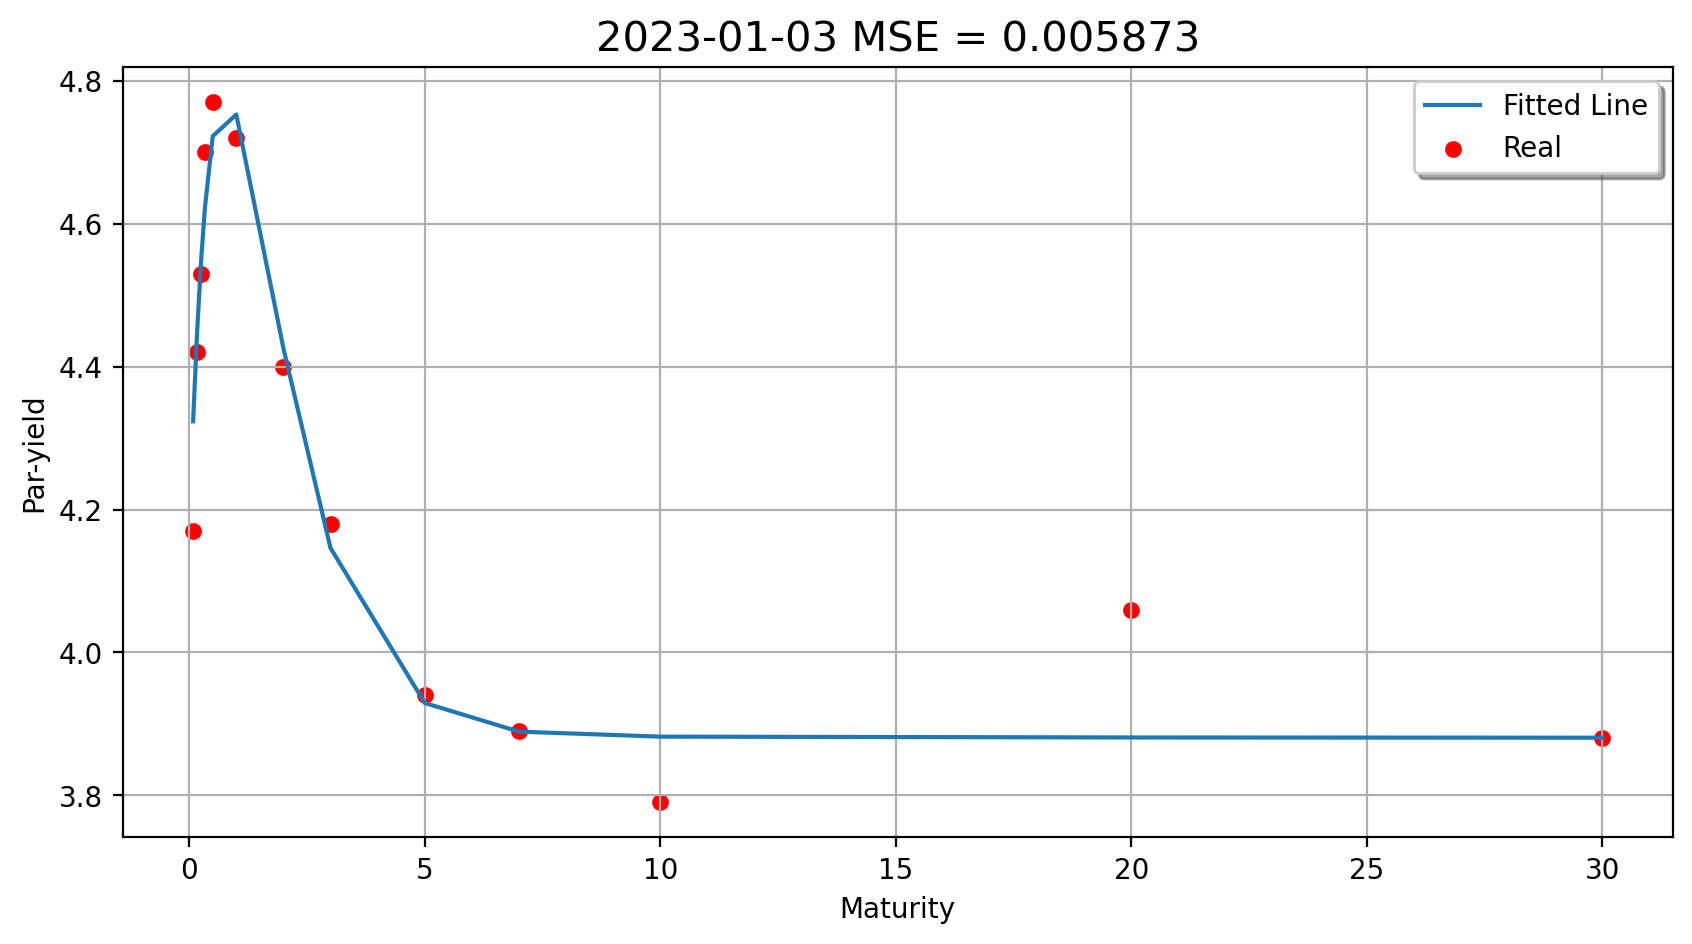

In [373]:
idx = 0

test = df.iloc[idx, :]
date = df.index[idx]

def nss(t, beta0, beta1, beta2, beta3, tau1, tau2):
    
    return beta0 + beta1 * (np.exp(-t / tau1)) + beta2 * ((np.exp(-t / tau1)) * (t / tau1)) + beta3 * (t/tau2)*np.exp(-t/tau2)

def error_functions (params):
    beta0, beta1, beta2, beta3, tau1, tau2 = params
    pred_rates = nss(t, beta0, beta1, beta2, beta3, tau1, tau2)
    
    error = ((pred_rates - observed_rates)**2).mean()
    return error

constraints = [{'type': 'ineq', 'fun': lambda x: x[0]-observed_rates[-1]},  # beta0 > 0
               {'type': 'ineq', 'fun': lambda x: x[1]-observed_rates[0]+observed_rates[-1]},  # beta1 > 0
               {'type': 'ineq', 'fun': lambda x: 30 - x[2]},  # beta2 > 0
               {'type': 'ineq', 'fun': lambda x: 30 - x[3]},  # beta3 > 0
               {'type': 'ineq', 'fun': lambda x: 5-x[4]},  # tau1 > 0
               {'type': 'ineq', 'fun': lambda x: x[5]-6}]  # tau2 > 0

t = np.array(array_list)
observed_rates = df.iloc[0, :].values

initial_params = [observed_rates[-1],\
                  observed_rates[0]-observed_rates[-1],\
                  0.3, 0.4, 1.0, 2.0]  # 초기 파라미터 값
result = minimize(error_functions, initial_params, method='SLSQP', constraints=constraints)
optimal_params = result.x  # 최적 파라미터 값

print(f'optimal_params : {np.round(optimal_params,4)}')

pred = nss(np.array(array_list), optimal_params[0], optimal_params[1], optimal_params[2], optimal_params[3], optimal_params[4], optimal_params[5])
pred = pd.DataFrame(index=array_list, data=pred, columns=['PRED'])
#pred = pd.DataFrame(index=df.columns, data=pred, columns=['PRED'])
y = test.values
#y = pd.DataFrame(index=array_list, data=y, columns=['Real'])
#y = pd.DataFrame(index=df.columns, data=y, columns=['Real'])

plt.figure(figsize=(10,5), dpi=200)
plt.title(f'{str(date)[0:10]} MSE = {np.round(((pred.T.values - y)**2).mean(), 6)}', size=15)
plt.plot(pred, label='Fitted Line')
#plt.xticks(df.columns, rotation=45)
plt.scatter(array_list, y, marker='o', linewidths=0.05, color='red', label='Real')
plt.grid()
plt.xlabel('Maturity')
plt.ylabel('Par-yield')
plt.legend(loc='best',fontsize=10, frameon=True, shadow=True)
plt.show()

optimal_params : [3.88   0.29   1.554  0.6167 0.8098 1.1956]


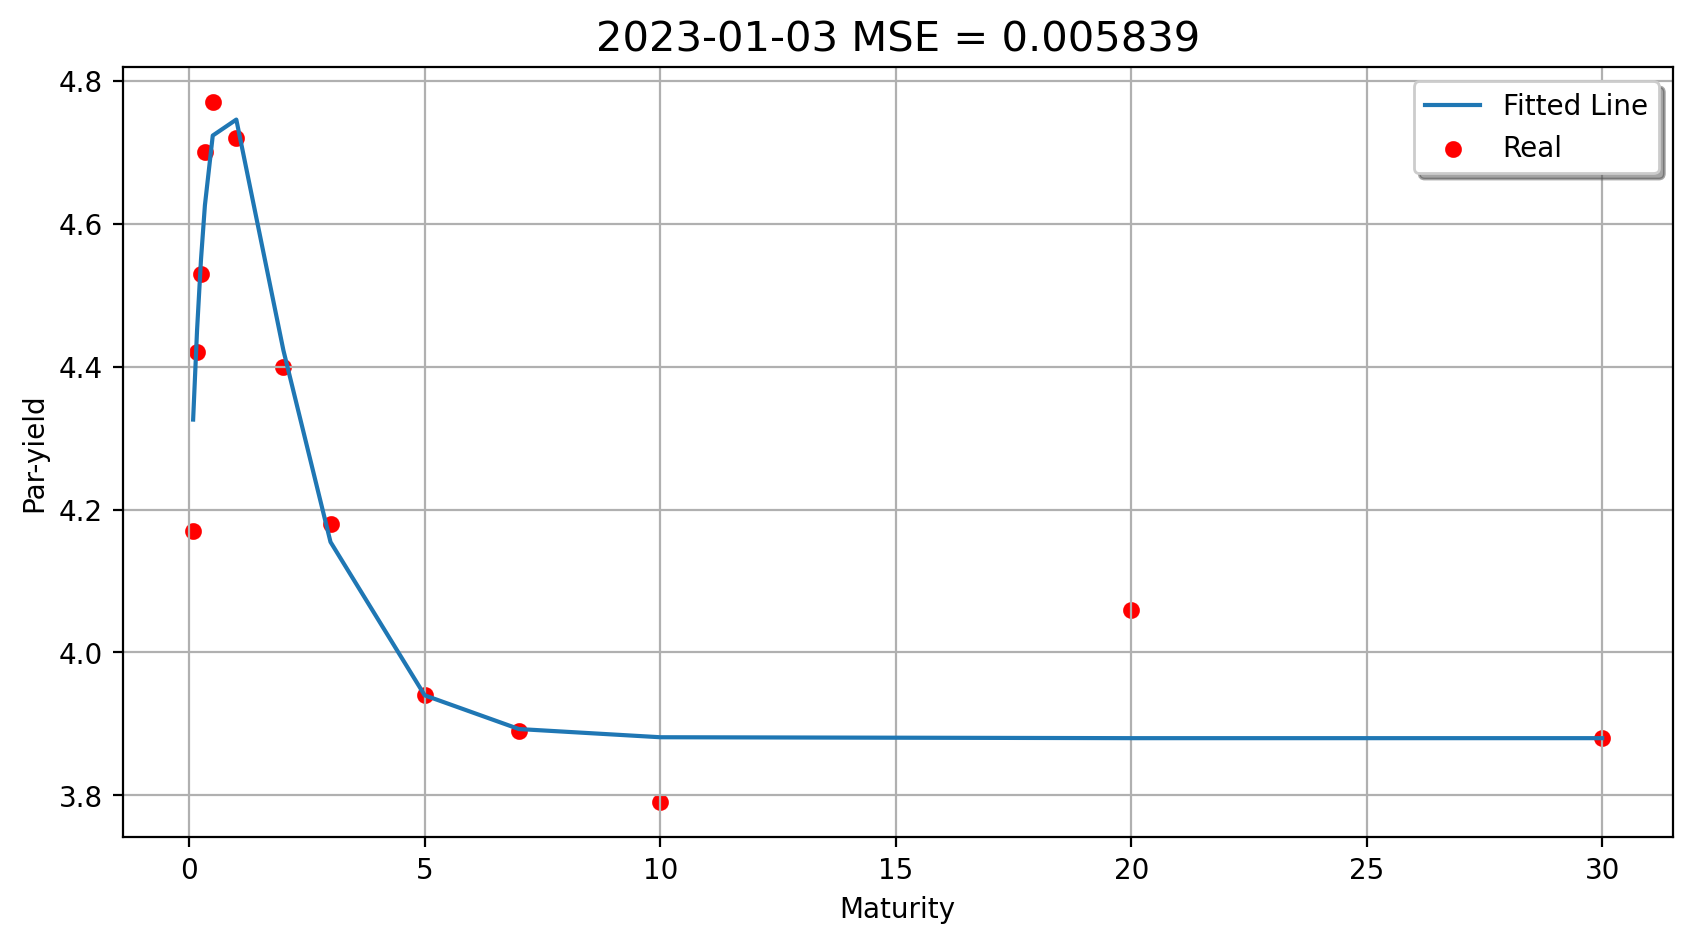

optimal_params : [ 3.55    1.0407  2.42   -0.5126  0.7543  0.2079]


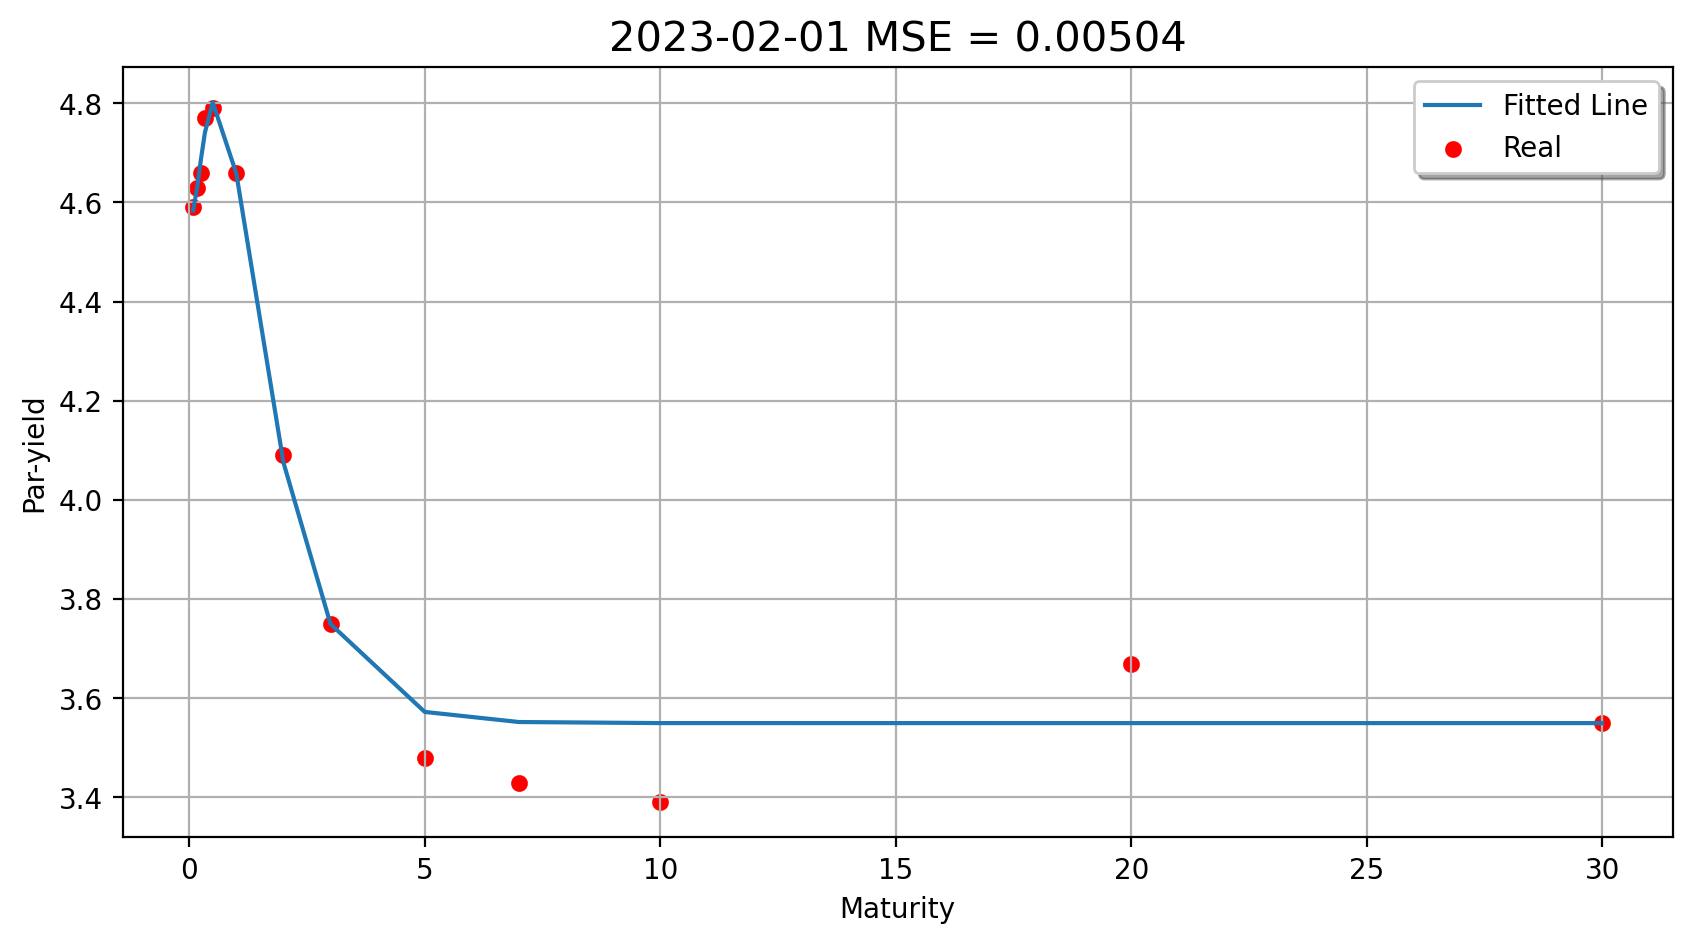

optimal_params : [4.0276 0.7    1.1766 1.0614 1.1825 1.5843]


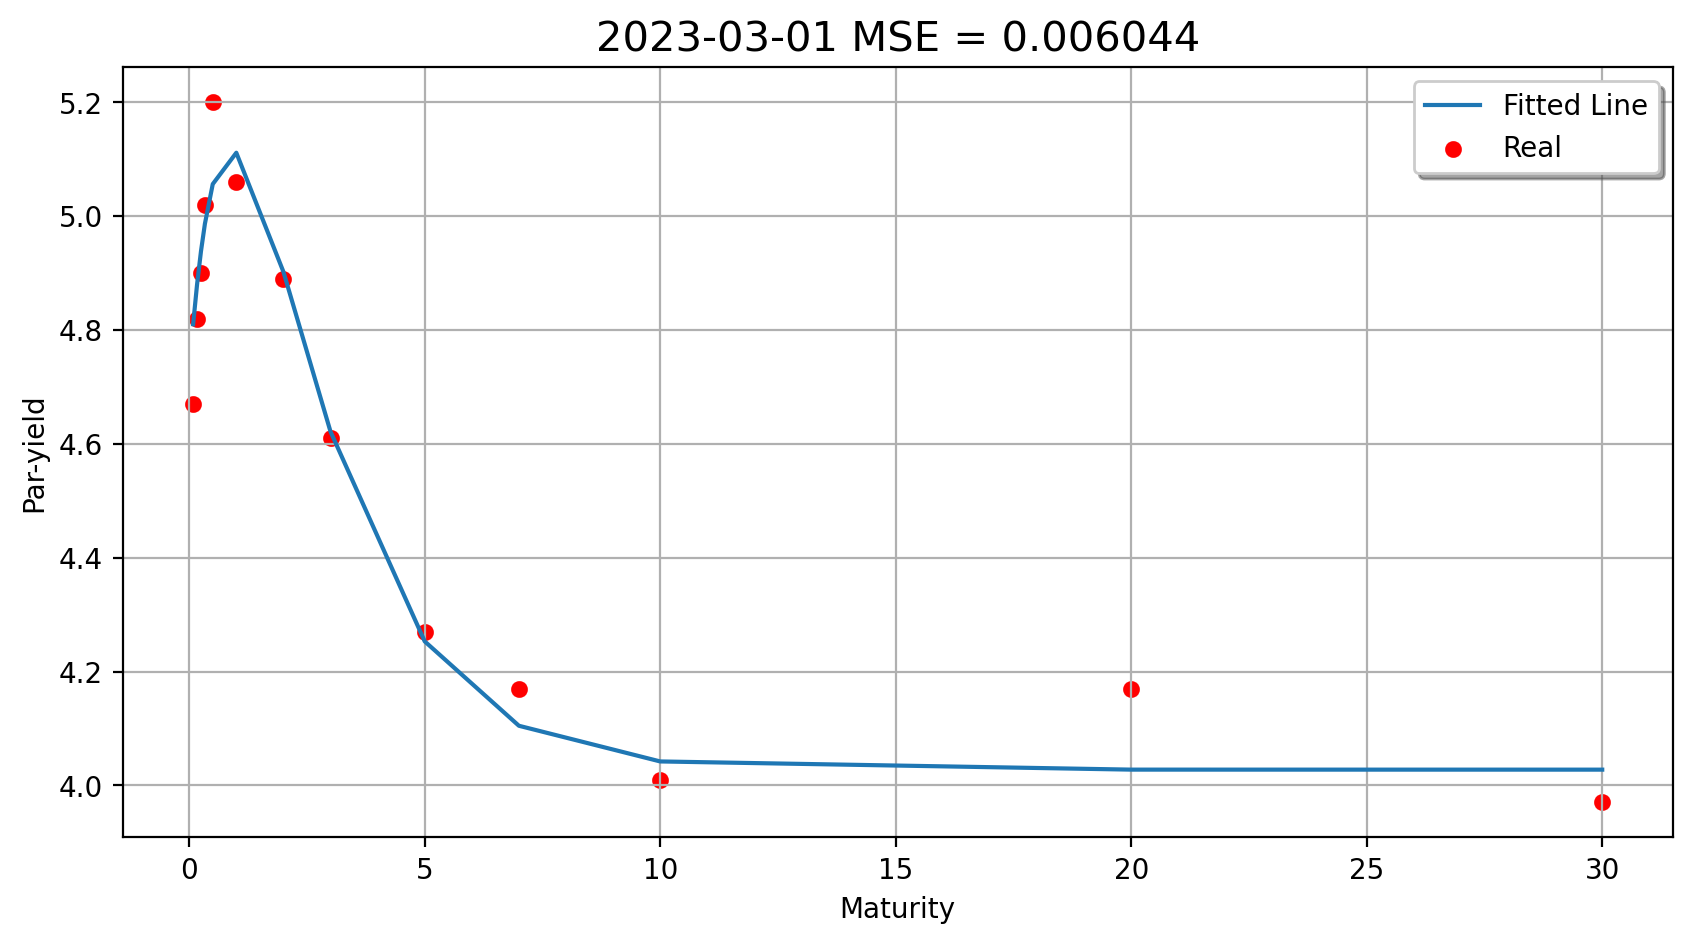

optimal_params : [ 3.6606  1.06    2.0857 -0.5387  0.7909  4.6062]


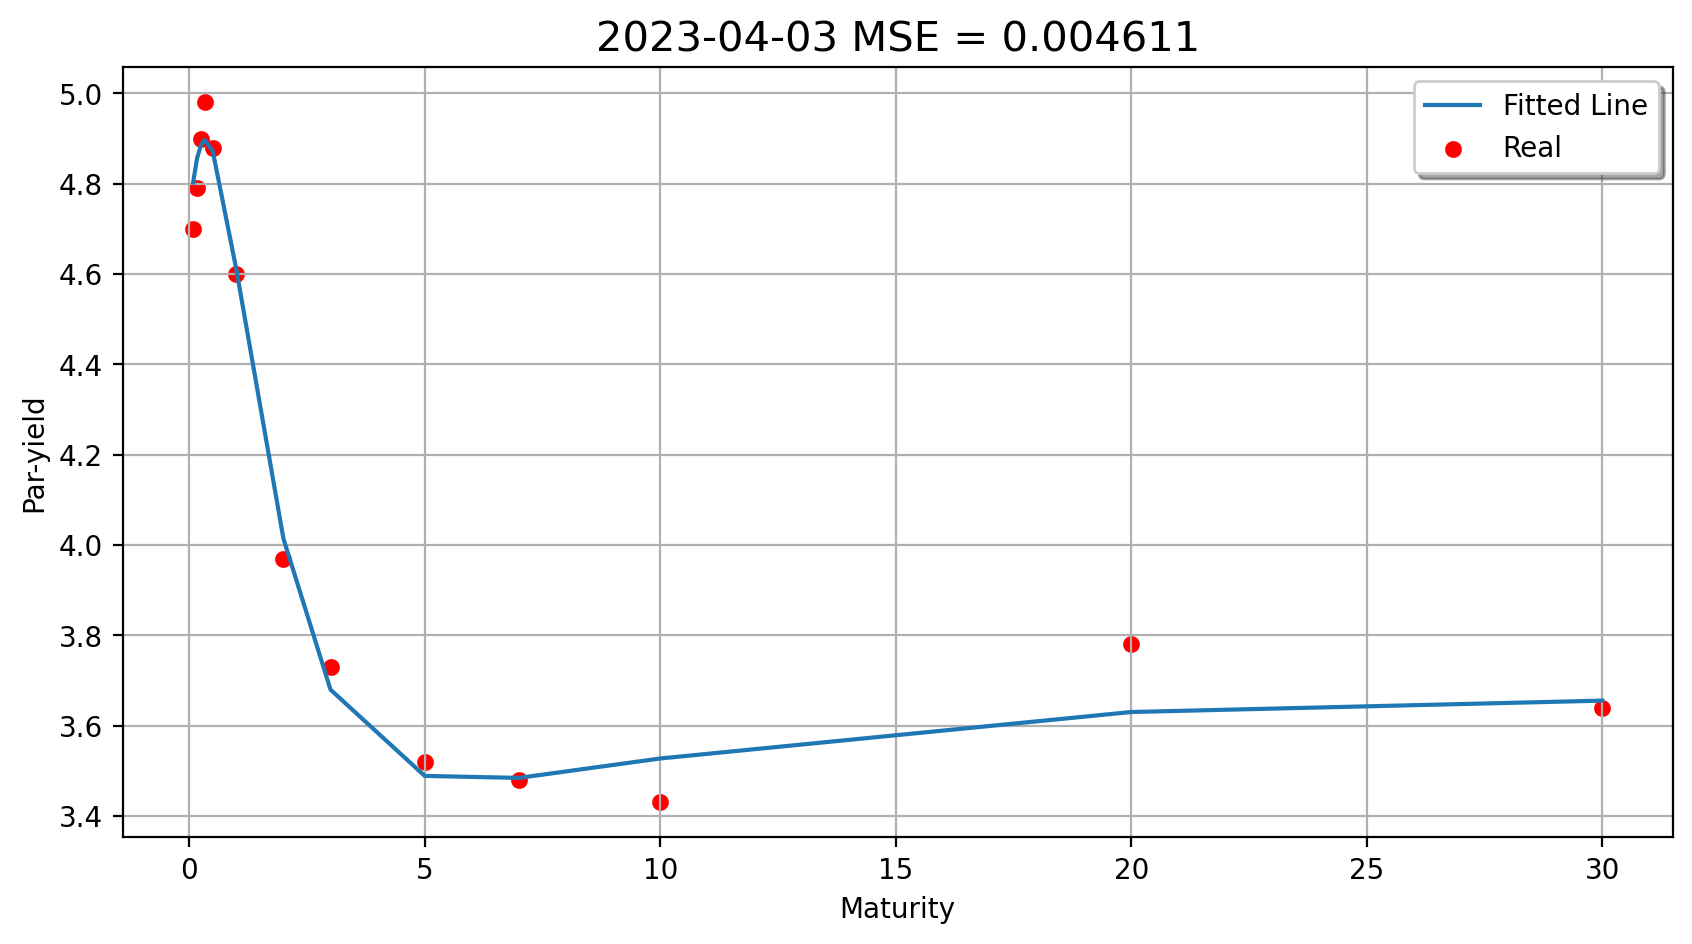

optimal_params : [ 3.8513  0.65    3.2103 -0.5913  0.6066  5.    ]


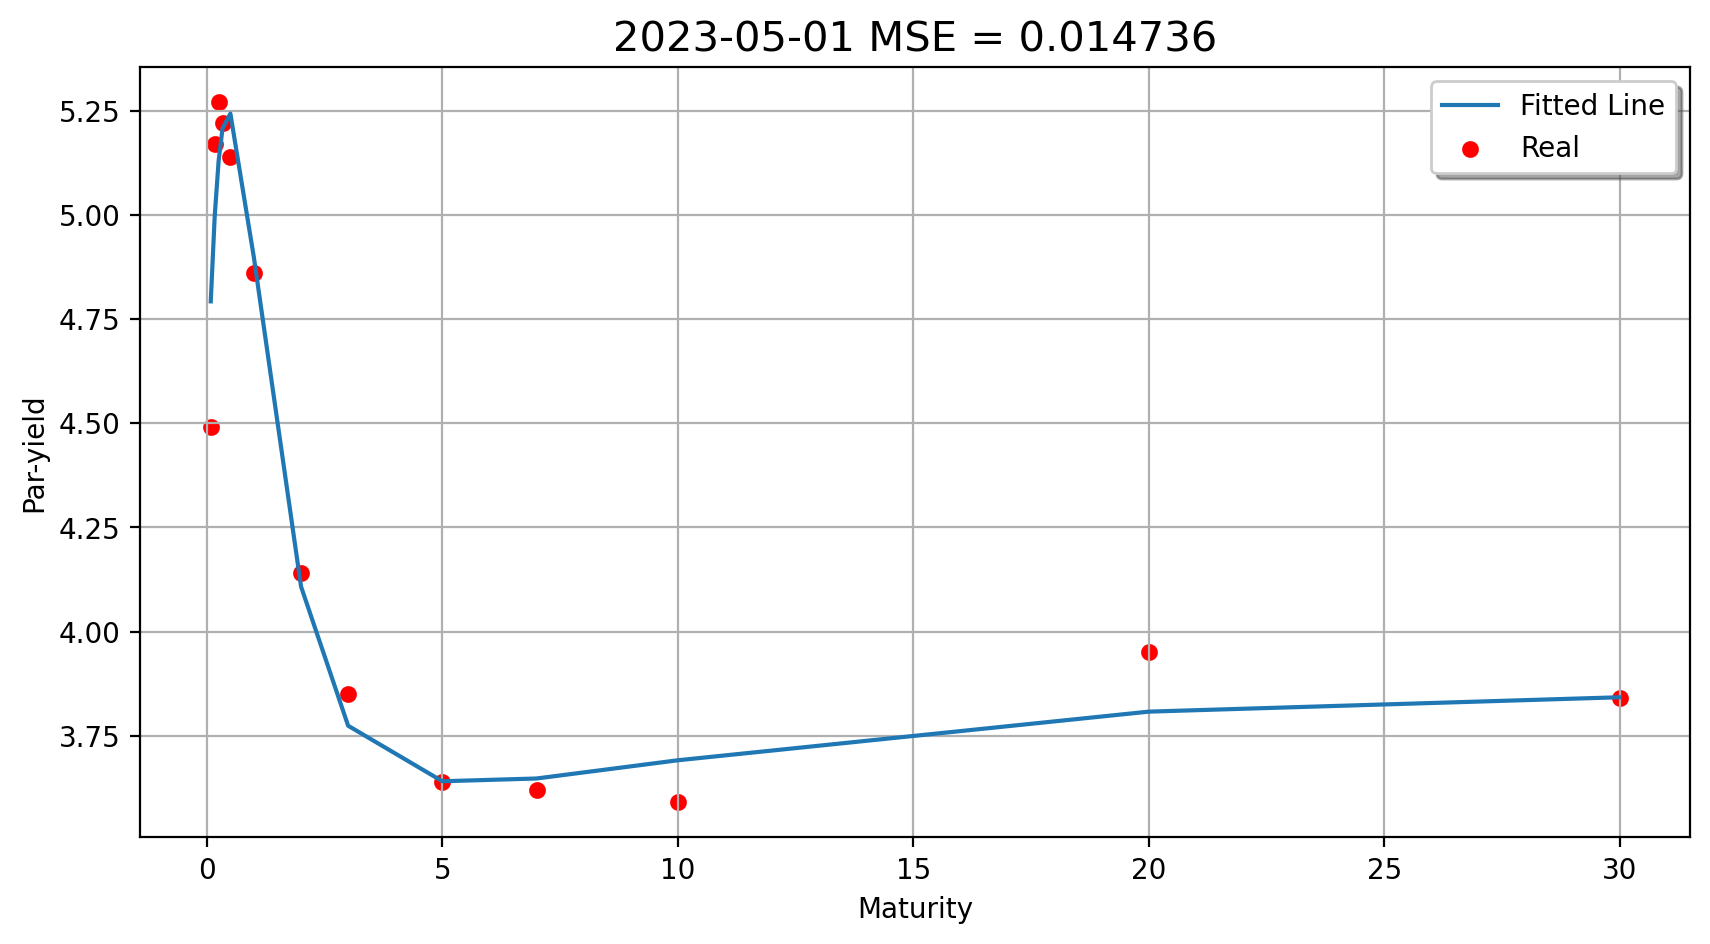

In [374]:
params_list = []

for date_idx_num in range(len(df)):

    idx = date_idx_num

    test = df.iloc[idx, :]
    date = df.index[idx]

    def nss(t, beta0, beta1, beta2, beta3, tau1, tau2):
        
        return beta0 + beta1 * (np.exp(-t / tau1)) + beta2 * ((np.exp(-t / tau1)) * (t / tau1)) + beta3 * (t/tau2)*np.exp(-t/tau2)

    def error_functions (params):
        beta0, beta1, beta2, beta3, tau1, tau2 = params
        pred_rates = nss(t, beta0, beta1, beta2, beta3, tau1, tau2)
        
        error = ((pred_rates - observed_rates)**2).mean()
        return error

    constraints = [{'type': 'ineq', 'fun': lambda x: x[0]-observed_rates[-1]},  # beta0 > 0
                {'type': 'ineq', 'fun': lambda x: x[1]-observed_rates[0]+observed_rates[-1]},  # beta1 > 0
                {'type': 'ineq', 'fun': lambda x: 30 - x[2]},  # beta2 > 0
                {'type': 'ineq', 'fun': lambda x: 30 - x[3]},  # beta3 > 0
                {'type': 'ineq', 'fun': lambda x: 5-x[4]},  # tau1 > 0
                {'type': 'ineq', 'fun': lambda x: 5-x[5]}]  # tau2 > 0

    t = np.array(array_list)
    observed_rates = test

    initial_params = [observed_rates[-1],\
                    observed_rates[0]-observed_rates[-1],\
                    0.3, 0.4, 1.0, 2.0]  # 초기 파라미터 값
    result = minimize(error_functions, initial_params, method='SLSQP', constraints=constraints)
    optimal_params = result.x  # 최적 파라미터 값

    print(f'optimal_params : {np.round(optimal_params,4)}')

    pred = nss(t, optimal_params[0], optimal_params[1], optimal_params[2], optimal_params[3], optimal_params[4], optimal_params[5])
    pred = pd.DataFrame(index=array_list, data=pred, columns=['PRED'])
    #pred = pd.DataFrame(index=df.columns, data=pred, columns=['PRED'])
    y = test.values
    #y = pd.DataFrame(index=array_list, data=y, columns=['Real'])
    #y = pd.DataFrame(index=df.columns, data=y, columns=['Real'])

    plt.figure(figsize=(10,5), dpi=200)
    plt.title(f'{str(date)[0:10]} MSE = {np.round(((pred.T.values - y)**2).mean(), 6)}', size=15)
    plt.plot(pred, label='Fitted Line')
    #plt.xticks(df.columns, rotation=45)
    plt.scatter(array_list, y, marker='o', linewidths=0.05, color='red', label='Real')
    plt.grid()
    plt.xlabel('Maturity')
    plt.ylabel('Par-yield')
    plt.legend(loc='best',fontsize=10, frameon=True, shadow=True)
    plt.show()

# 6.

In [375]:
df_daily = pd.read_csv('./DATA/daily-treasury-rates.csv', index_col=0, parse_dates=True).sort_index()
#df_daily = df_daily.loc[[df_daily.index[df_daily.index.month == x+1][0] for x in range(5)]]
df_daily.head()

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
Date,,,,,,,,,,,,,
2023-01-03,4.17,4.42,4.53,4.70,4.77,4.72,4.40,4.18,3.94,3.89,3.79,4.06,3.88
2023-01-04,4.20,4.42,4.55,4.69,4.77,4.71,4.36,4.11,3.85,3.79,3.69,3.97,3.81
2023-01-05,4.30,4.55,4.66,4.75,4.81,4.78,4.45,4.18,3.90,3.82,3.71,3.96,3.78
2023-01-06,4.32,4.55,4.67,4.74,4.79,4.71,4.24,3.96,3.69,3.63,3.55,3.84,3.67
2023-01-09,4.37,4.58,4.70,4.74,4.83,4.69,4.19,3.93,3.66,3.60,3.53,3.83,3.66


In [376]:
params_list = []

for date_idx_num in range(len(df_daily)):

    idx = date_idx_num

    test = df_daily.iloc[idx, :]
    date = df_daily.index[idx]

    def nss(t, beta0, beta1, beta2, beta3, tau1, tau2):
        
        return beta0 + beta1 * (np.exp(-t / tau1)) + beta2 * ((np.exp(-t / tau1)) * (t / tau1)) + beta3 * (t/tau2)*np.exp(-t/tau2)

    def error_functions (params):
        beta0, beta1, beta2, beta3, tau1, tau2 = params
        pred_rates = nss(t, beta0, beta1, beta2, beta3, tau1, tau2)
        
        error = np.sum((pred_rates - observed_rates)**2)
        return error

    constraints = [{'type': 'ineq', 'fun': lambda x: x[0]-observed_rates[-1]},  # beta0 > 0
                {'type': 'ineq', 'fun': lambda x: x[1]-observed_rates[0]+observed_rates[-1]},  # beta1 > 0
                {'type': 'ineq', 'fun': lambda x: 30 - x[2]},  # beta2 > 0
                {'type': 'ineq', 'fun': lambda x: 30 - x[3]},  # beta3 > 0
                {'type': 'ineq', 'fun': lambda x: 5-x[4]},  # tau1 > 0
                {'type': 'ineq', 'fun': lambda x: 5-x[5]}]  # tau2 > 0

    t = np.array(array_list)
    observed_rates = df_daily.iloc[idx, :].values

    initial_params = [observed_rates[-1],\
                    observed_rates[0]-observed_rates[-1],\
                    0.3, 0.4, 1.0, 2.0]  # 초기 파라미터 값
    result = minimize(error_functions, initial_params, method='SLSQP', constraints=constraints)
    optimal_params = result.x  # 최적 파라미터 값

    params_list.append(optimal_params)

    # print(f'optimal_params : {optimal_params}')

    pred = nss(np.array(array_list), optimal_params[0], optimal_params[1], optimal_params[2], optimal_params[3], optimal_params[4], optimal_params[5])
    pred = pd.DataFrame(index=array_list, data=pred, columns=['PRED'])
    y = test.values
    y = pd.DataFrame(index=array_list, data=y, columns=['Real'])

    # plt.figure(figsize=(10,5), dpi=200)
    # plt.title(f'{str(date)[0:10]} mse: {np.round(np.sum((y.values-pred.values)**2),2)}')
    # plt.plot(y, label='True')
    # plt.plot(pred, label='fitted')
    # plt.legend()
    # plt.grid()

/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_10239/2369122522.py:12: RuntimeWarning: overflow encountered in exp
  return beta0 + beta1 * (np.exp(-t / tau1)) + beta2 * ((np.exp(-t / tau1)) * (t / tau1)) + beta3 * (t/tau2)*np.exp(-t/tau2)
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_10239/2369122522.py:12: RuntimeWarning: invalid value encountered in add
  return beta0 + beta1 * (np.exp(-t / tau1)) + beta2 * ((np.exp(-t / tau1)) * (t / tau1)) + beta3 * (t/tau2)*np.exp(-t/tau2)
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_10239/2369122522.py:18: RuntimeWarning: overflow encountered in square
  error = np.sum((pred_rates - observed_rates)**2)
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_10239/2369122522.py:18: RuntimeWarning: overflow encountered in square
  error = np.sum((pred_rates - observed_rates)**2)
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_10239/2369122522.py:12: RuntimeWarning: overflow encountered in exp
  

In [377]:
reg_params = pd.DataFrame(params_list, index=df_daily.index, columns=[['beta0', 'beta1', 'beta2', 'beta3', 'tau1', 'tau2']])

In [378]:
import datetime as dt

In [379]:
time_weighted_index = 1/(dt.datetime.today() - reg_params.index).days / np.sum(1/(dt.datetime.today() - reg_params.index).days)

In [380]:
time_weighted_index.to_frame().values

array([[0.002208  ],
       [0.00222323],
       [0.00223867],
       [0.00225432],
       [0.00230263],
       [0.00231919],
       [0.002336  ],
       [0.00235305],
       [0.00237035],
       [0.00244218],
       [0.00246082],
       [0.00247975],
       [0.00249898],
       [0.00255848],
       [0.00257894],
       [0.00259974],
       [0.00262088],
       [0.00264236],
       [0.00270897],
       [0.00273193],
       [0.00275528],
       [0.00277903],
       [0.0028032 ],
       [0.00287829],
       [0.00290422],
       [0.00293062],
       [0.0029575 ],
       [0.00298489],
       [0.00307017],
       [0.00309969],
       [0.00312979],
       [0.00316047],
       [0.00319176],
       [0.00332338],
       [0.003358  ],
       [0.00339335],
       [0.00342945],
       [0.00354251],
       [0.00358187],
       [0.00362211],
       [0.00366327],
       [0.00370538],
       [0.00383771],
       [0.00388395],
       [0.00393132],
       [0.00397985],
       [0.0040296 ],
       [0.004

In [381]:
time_weighted_params = (reg_params * time_weighted_index.to_frame().values).sum().to_list()
(reg_params * time_weighted_index.to_frame().values).sum()

beta0    3.852241
beta1    1.448435
beta2    1.603653
beta3   -1.414761
tau1     1.449018
tau2     2.952931
dtype: float64

In [382]:
t = np.array(array_list)
curve_pred = nss(t,
                time_weighted_params[0],
                time_weighted_params[1],
                time_weighted_params[2],
                time_weighted_params[3],
                time_weighted_params[4],
                time_weighted_params[5])
curve_pred = pd.DataFrame(index=t, data=curve_pred, columns=['pred'])
curve_pred

,pred
0.083333,5.267984
0.166667,5.232244
0.250000,5.193928
0.333333,5.153466
0.500000,5.067627
1.000000,4.792213
2.000000,4.286503
3.000000,3.933352
5.000000,3.633161
7.000000,3.612274


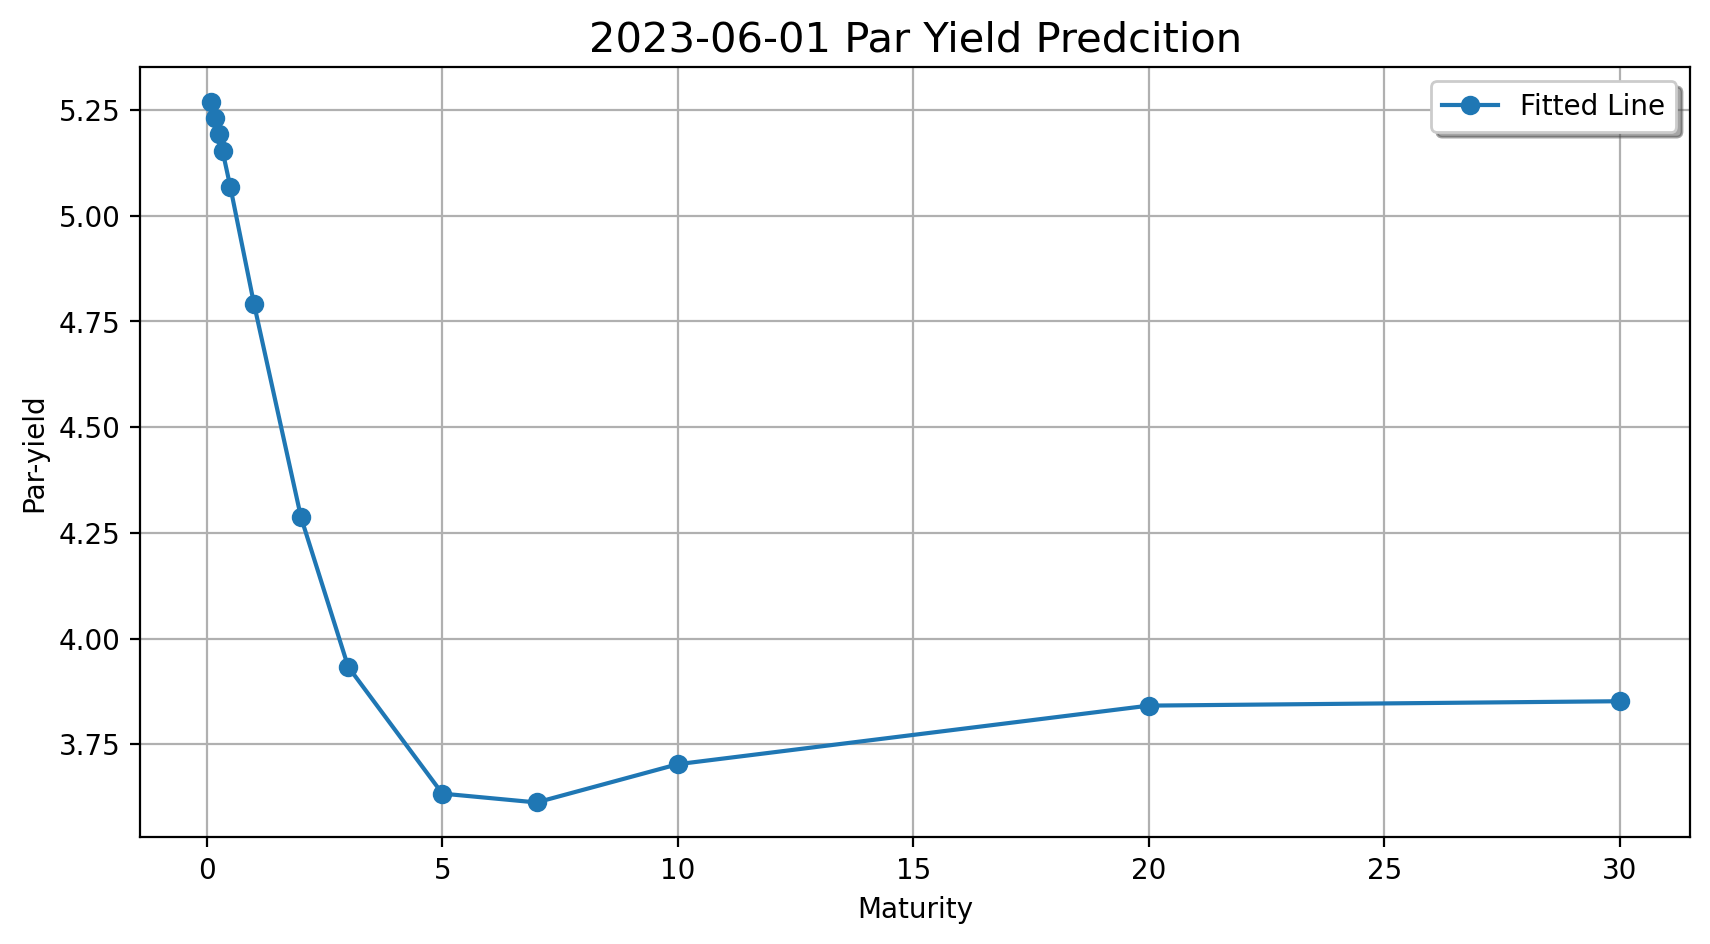

In [383]:
plt.figure(figsize=(10,5), dpi=200)
plt.title('2023-06-01 Par Yield Predcition', size=15)
plt.plot(curve_pred, '-o', label='Fitted Line')
#plt.xticks(df.columns, rotation=45)
#plt.scatter(array_list, y, marker='o', linewidths=0.05, color='red', label='Real')
plt.grid()
plt.xlabel('Maturity')
plt.ylabel('Par-yield')
plt.legend(loc='best',fontsize=10, frameon=True, shadow=True)
plt.show()